<a href="https://colab.research.google.com/github/YuriArduino/Estudos_Artificial_Intelligence/blob/Imers%C3%A3o-Agentes-de-IA---Alura/RAG_Evaluation_and_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Célula 1: Instalações e Imports
# Execute esta célula primeiro no Colab.

# Instalações (adapte conforme sua necessidade)
!pip -q install -q pandas matplotlib seaborn langchain_community langchain_google_genai faiss-cpu pymupdf requests

# Imports do sistema e de dados
import os
import json
import time
import re
import requests
import tempfile
import statistics
import traceback
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional, Tuple
from datetime import datetime
from urllib.parse import unquote

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Imports do LangChain / integrações (conforme seu setup)
# NOTE: nomes de pacotes podem variar por versão; ajuste se necessário.
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

# Ajustes de visualização
pd.options.display.max_colwidth = 300
sns.set()  # usa as configurações padrão do seaborn (não forçamos cores)


In [14]:
# Célula 2: Definição do Framework de Análise (com robustez adicionada)

@dataclass
class ChunkAnalysisResult:
    id: int
    content: str
    score: float
    is_relevant: bool
    confidence_score: Optional[float] = None
    reasoning: Optional[str] = None
    evaluation_time: Optional[float] = None

@dataclass
class RetrievalExperiment:
    chunk_size: int
    chunk_overlap: int
    total_chunks: int
    query: str
    k_tested: int
    results: List[ChunkAnalysisResult]
    recommended_k: Optional[int] = None
    recommended_threshold: Optional[float] = None
    precision_at_k: Optional[Dict[int, float]] = None
    recall_estimate: Optional[float] = None
    execution_time: Optional[float] = None
    cost_estimate: Optional[float] = None

class LLMAdapter:
    """
    Adapter leve para normalizar diferentes clients de LLM.
    Fornece método .invoke(prompt) que retorna um objeto com .content (string),
    mas aceita várias formas de resposta de libs diferentes.
    """
    def __init__(self, llm):
        self.llm = llm

    def invoke(self, prompt: str, max_retries: int = 2, retry_backoff: float = 1.0):
        last_exc = None
        for attempt in range(max_retries + 1):
            try:
                # Tenta várias interfaces comuns
                if hasattr(self.llm, "invoke"):
                    resp = self.llm.invoke(prompt)
                    return self._normalize_response(resp)
                if hasattr(self.llm, "generate"):
                    resp = self.llm.generate([prompt])
                    return self._normalize_response(resp)
                # callable (ex: function model)
                resp = self.llm(prompt)
                return self._normalize_response(resp)
            except Exception as e:
                last_exc = e
                if attempt < max_retries:
                    time.sleep(retry_backoff * (2 ** attempt))
                else:
                    # Retorna objeto simples contendo o erro
                    return {"content": f"__LLM_ERROR__: {str(e)}"}
        return {"content": f"__LLM_ERROR__: {str(last_exc)}"}

    def _normalize_response(self, resp):
        """
        Extrai texto de várias possíveis estruturas de resposta.
        Retorna objeto simples com campo 'content'.
        """
        try:
            # Caso já seja dict-like
            if isinstance(resp, dict) and "content" in resp:
                return resp
            # LangChain generative responses podem ter .generations
            if hasattr(resp, "generations"):
                # resp.generations é lista de lists
                gen = resp.generations[0][0]
                text = getattr(gen, "text", str(gen))
                return {"content": text}
            # Alguns clientes retornam um objeto com .content ou .text
            if hasattr(resp, "content"):
                return {"content": resp.content}
            if hasattr(resp, "text"):
                return {"content": resp.text}
            # Se for string
            if isinstance(resp, str):
                return {"content": resp}
            # Fallback: cast para str
            return {"content": str(resp)}
        except Exception as e:
            return {"content": f"__LLM_NORMALIZE_ERROR__: {e} -- raw: {str(resp)}"}

class AdvancedRAGAnalyzer:
    def __init__(self, vectorstore, llm, cost_per_token: float = 0.0001):
        self.vectorstore = vectorstore
        self.llm_adapter = LLMAdapter(llm)
        self.cost_per_token = cost_per_token
        self.experiments_history: List[RetrievalExperiment] = []
        # atributos mutáveis usados por funções de comparação
        self.current_chunk_size = None
        self.current_chunk_overlap = None
        self.total_chunks = None

    def evaluate_chunk_relevance(self, query: str, chunk_content: str, use_reasoning: bool = True) -> Tuple[bool, float, str, float]:
        """
        Avalia a relevância de um chunk usando o LLM. Retorna:
        (is_relevant, confidence, reasoning, evaluation_time)
        """
        content = chunk_content[:700] + "..." if len(chunk_content) > 700 else chunk_content
        if use_reasoning:
            prompt = f"""
Avalie CRITICAMENTE se o CONTEXTO fornecido é relevante para responder à PERGUNTA.

PERGUNTA: "{query}"
CONTEXTO: "{content}"

INSTRUÇÕES:
1. Analise se o contexto contém informações que REALMENTE ajudam a responder à pergunta.
2. Seja rigoroso: contexto apenas relacionado ao tema NÃO é suficiente.
3. Forneça um score de confiança de 0 a 100.
4. Justifique brevemente sua decisão (máx 50 palavras).

FORMATO DE RESPOSTA (obrigatório):
DECISÃO: [SIM/NÃO]
CONFIANÇA: [0-100]
JUSTIFICATIVA: [texto]
"""
        else:
            prompt = f"""
O contexto a seguir é relevante para responder à pergunta?

PERGUNTA: "{query}"
CONTEXTO: "{content}"

Responda apenas: SIM ou NÃO
"""
        start = time.time()
        resp = self.llm_adapter.invoke(prompt)
        eval_time = time.time() - start

        raw_text = resp.get("content", "").strip()

        # Tratamento de erro do LLM
        if raw_text.startswith("__LLM_ERROR__") or raw_text.startswith("__LLM_NORMALIZE_ERROR__"):
            # fallback conservador
            return False, 0.0, f"LLM_ERROR: {raw_text}", eval_time

        # Parsing robusto via regex
        try:
            decision = False
            confidence = 50.0
            reasoning = "N/A"

            # Busca decisão
            dec_m = re.search(r"DECISÃO\s*:\s*(SIM|NÃO|NAO|YES|NO)", raw_text, re.IGNORECASE)
            if dec_m:
                decision = dec_m.group(1).upper() in ("SIM", "YES")
            else:
                # fallback: verifica presença de SIM/NÃO na resposta
                decision = bool(re.search(r"\bSIM\b", raw_text, re.IGNORECASE))

            # Busca confiança
            conf_m = re.search(r"CONFIANÇA\s*:\s*(\d{1,3})", raw_text, re.IGNORECASE)
            if conf_m:
                confidence = float(conf_m.group(1))
            else:
                # procura percentuais na resposta
                perc_m = re.search(r"(\d{1,3})\s*%", raw_text)
                if perc_m:
                    confidence = float(perc_m.group(1))

            # Busca justificativa
            just_m = re.search(r"JUSTIFICATIVA\s*:\s*(.+)", raw_text, re.IGNORECASE | re.DOTALL)
            if just_m:
                reasoning = just_m.group(1).strip()
                # trim para 200 chars para segurança
                if len(reasoning) > 300:
                    reasoning = reasoning[:300] + "..."
            else:
                # pega primeira linha após respostas se não houver label
                lines = [ln.strip() for ln in raw_text.splitlines() if ln.strip()]
                if len(lines) >= 2:
                    reasoning = lines[1][:300]

            # garante limites
            confidence = max(0.0, min(100.0, float(confidence)))
        except Exception as e:
            # parsing falhou -> fallback
            reason = f"PARSE_ERROR: {e}"
            return False, 0.0, reason, eval_time

        return decision, confidence, reasoning, eval_time

    def calculate_metrics(self, results: List[ChunkAnalysisResult], k_values: List[int] = None) -> Dict[str, Any]:
        if k_values is None:
            k_values = [1, 2, 3, 5, len(results)]

        sorted_results = sorted(results, key=lambda x: x.score)  # assume menor = melhor
        precision_at_k = {}
        for k in k_values:
            if k <= len(sorted_results) and k > 0:
                relevant_in_top_k = sum(1 for r in sorted_results[:k] if r.is_relevant)
                precision_at_k[k] = relevant_in_top_k / k

        total_relevant = sum(1 for r in results if r.is_relevant)
        total_docs = len(results)
        best_threshold = self._find_optimal_threshold(sorted_results)

        relevant_scores = [r.score for r in results if r.is_relevant]
        irrelevant_scores = [r.score for r in results if not r.is_relevant]

        return {
            'precision_at_k': precision_at_k,
            'total_relevant': total_relevant,
            'total_retrieved': total_docs,
            'overall_precision': (total_relevant / total_docs) if total_docs > 0 else 0,
            'best_threshold': best_threshold,
            'score_statistics': {
                'relevant_scores': {
                    'mean': statistics.mean(relevant_scores) if relevant_scores else 0,
                    'median': statistics.median(relevant_scores) if relevant_scores else 0,
                    'std': statistics.stdev(relevant_scores) if len(relevant_scores) > 1 else 0
                },
                'irrelevant_scores': {
                    'mean': statistics.mean(irrelevant_scores) if irrelevant_scores else 0,
                    'median': statistics.median(irrelevant_scores) if irrelevant_scores else 0,
                    'std': statistics.stdev(irrelevant_scores) if len(irrelevant_scores) > 1 else 0
                }
            }
        }

    def _find_optimal_threshold(self, sorted_results: List[ChunkAnalysisResult]) -> float:
        if not sorted_results:
            return 0.0
        best_threshold = sorted_results[-1].score
        best_f1 = 0.0
        total_relevant_global = sum(1 for r in sorted_results if r.is_relevant)
        for i, r in enumerate(sorted_results):
            threshold = r.score
            filtered = [x for x in sorted_results if x.score <= threshold]
            if not filtered:
                continue
            relevant_retrieved = sum(1 for x in filtered if x.is_relevant)
            total_retrieved = len(filtered)
            precision = relevant_retrieved / total_retrieved if total_retrieved else 0
            recall = relevant_retrieved / total_relevant_global if total_relevant_global else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        # Adiciona a conversão para float padrão
        return float(best_threshold)

    def analyze_retriever_comprehensive(self, query: str, k_values: List[int] = None,
                                       use_reasoning: bool = True, save_results: bool = True) -> Optional[RetrievalExperiment]:
        if k_values is None:
            k_values = [3, 5, 8, 10]
        max_k = max(k_values)
        start_time = time.time()
        print("\n" + "="*120)
        print("🔍 ANÁLISE COMPREHENSIVA DE RAG RETRIEVER")
        print(f"Query: {query}")
        print(f"Testando k = {k_values}")
        print("="*120)

        try:
            docs_with_scores = self.vectorstore.similarity_search_with_score(query, k=max_k)
        except Exception as e:
            print(f"❌ Erro ao recuperar do vectorstore: {e}")
            traceback.print_exc()
            return None

        if not docs_with_scores:
            print("❌ Nenhum documento encontrado!")
            return None

        results: List[ChunkAnalysisResult] = []
        for i, (doc, score) in enumerate(docs_with_scores):
            print(f"\n--- Chunk {i+1}/{len(docs_with_scores)}  (score: {score:.6f}) ---")
            try:
                is_relevant, confidence, reasoning, eval_time = self.evaluate_chunk_relevance(
                    query, getattr(doc, "page_content", str(doc)), use_reasoning=use_reasoning
                )
            except Exception as e:
                print(f"⚠️ Erro avaliando chunk {i+1}: {e}")
                is_relevant, confidence, reasoning, eval_time = False, 0.0, f"ERROR: {e}", 0.0

            content_preview = getattr(doc, "page_content", str(doc))[:300]
            result = ChunkAnalysisResult(
                id=i+1,
                content=content_preview + ("..." if len(content_preview) >= 300 else ""),
                score=float(score),
                is_relevant=is_relevant,
                confidence_score=confidence,
                reasoning=reasoning,
                evaluation_time=eval_time
            )
            results.append(result)
            status = "✅ Relevante" if is_relevant else "❌ Irrelevante"
            print(f"{status} (confiança: {confidence:.0f}%) — tempo: {eval_time:.2f}s")
            if use_reasoning:
                print(f"  Justificativa (preview): {reasoning[:200]}")

        metrics = self.calculate_metrics(results, k_values)
        recommendations = self._generate_recommendations(results, metrics, k_values)
        execution_time = time.time() - start_time

        experiment = RetrievalExperiment(
            chunk_size=self.current_chunk_size or -1,
            chunk_overlap=self.current_chunk_overlap or -1,
            total_chunks=self.total_chunks or len(results),
            query=query,
            k_tested=max_k,
            results=results,
            recommended_k=recommendations.get('optimal_k'),
            recommended_threshold=recommendations.get('optimal_threshold'),
            precision_at_k=metrics.get('precision_at_k'),
            execution_time=execution_time
        )

        # Exibição resumida
        self._display_comprehensive_results(experiment, metrics, recommendations)

        if save_results:
            self.experiments_history.append(experiment)

        return experiment

    def _generate_recommendations(self, results: List[ChunkAnalysisResult], metrics: Dict, k_values: List[int]) -> Dict:
        precision_at_k = metrics.get('precision_at_k', {})
        optimal_k = min(k_values)
        # tenta encontrar primeiro k com precision >= 0.5, senão pega melhor
        for k in k_values:
            if precision_at_k.get(k, 0) >= 0.5:
                optimal_k = k
                break
        if precision_at_k:
            best_k_item = max(precision_at_k.items(), key=lambda x: x[1])
            if precision_at_k.get(optimal_k, 0) < best_k_item[1]:
                optimal_k = best_k_item[0]
        conf_level = 'HIGH' if metrics.get('overall_precision', 0) > 0.7 else 'MEDIUM' if metrics.get('overall_precision', 0) > 0.4 else 'LOW'
        return {'optimal_k': optimal_k, 'optimal_threshold': metrics.get('best_threshold', 0.0), 'confidence_level': conf_level}

    def _display_comprehensive_results(self, experiment: RetrievalExperiment, metrics: Dict, recommendations: Dict):
        print("\n" + "="*100)
        print("📊 RESULTADOS DA ANÁLISE (Resumo)")
        print("="*100)
        print(f"Precision Geral: {metrics.get('overall_precision', 0):.2%}")
        print(f"Docs Relevantes: {metrics.get('total_relevant', 0)}/{metrics.get('total_retrieved', 0)}")
        print(f"Threshold Ótimo: {metrics.get('best_threshold', 0):.6f}")
        print("\nPrecision@K:")
        for k, v in sorted(metrics.get('precision_at_k', {}).items()):
            print(f"  P@{k}: {v:.2%}")
        print("\nRecomendações:")
        print(f"  K recomendado: {recommendations.get('optimal_k')}")
        print(f"  Threshold recomendado: {recommendations.get('optimal_threshold'):.6f}")
        print(f"  Confiança geral: {recommendations.get('confidence_level')}")
        print(f"\nTempo de Execução: {experiment.execution_time:.2f}s")
        print("="*100)

    def compare_chunk_strategies(self, strategies: List[Dict], query: str, k_test: int = 5) -> pd.DataFrame:
        comparison_results = []
        for i, strategy in enumerate(strategies):
            self.current_chunk_size = strategy.get('chunk_size')
            self.current_chunk_overlap = strategy.get('chunk_overlap')
            print(f"\nTestando estratégia {i+1}: {strategy.get('name')} ({self.current_chunk_size}/{self.current_chunk_overlap})")
            # Espera-se que o caller crie chunks e vectorstore e atualize self.vectorstore e self.total_chunks
            exp = self.analyze_retriever_comprehensive(query=query, k_values=[k_test], use_reasoning=True, save_results=False)
            if exp:
                comparison_results.append({
                    'Strategy': strategy.get('name'),
                    'Chunk_Size': self.current_chunk_size,
                    'Chunk_Overlap': self.current_chunk_overlap,
                    'Precision': exp.precision_at_k.get(k_test, 0) if exp.precision_at_k else 0,
                    'Relevant_Docs': sum(1 for r in exp.results if r.is_relevant),
                    'Avg_Confidence': statistics.mean([r.confidence_score for r in exp.results]) if exp.results else 0,
                    'Recommended_K': exp.recommended_k,
                    'Recommended_Threshold': exp.recommended_threshold,
                    'Execution_Time': exp.execution_time
                })
        df = pd.DataFrame(comparison_results)
        if not df.empty:
            best = df.loc[df['Precision'].idxmax()]
            print(f"\nMelhor estratégia: {best['Strategy']} (Precision: {best['Precision']:.2%})")
        return df

    def export_analysis_report(self, filepath: str = None):
        if not filepath:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filepath = f"/content/rag_analysis_report_{timestamp}.json"

        report = {
            'analysis_timestamp': datetime.now().isoformat(),
            'total_experiments': len(self.experiments_history),
            'experiments': []
        }
        for exp in self.experiments_history:
            exp_summary = {
                'chunk_size': exp.chunk_size,
                'chunk_overlap': exp.chunk_overlap,
                'query': exp.query,
                'recommended_k': exp.recommended_k,
                'recommended_threshold': exp.recommended_threshold,
                'precision_at_k': exp.precision_at_k,
                'execution_time': exp.execution_time,
                'total_chunks': len(exp.results),
                'relevant_chunks': sum(1 for r in exp.results if r.is_relevant),
                'avg_confidence': statistics.mean([r.confidence_score for r in exp.results]) if exp.results else 0
            }
            report['experiments'].append(exp_summary)

        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(report, f, ensure_ascii=False, indent=2)

        print(f"💾 Relatório salvo em: {filepath}")
        return filepath


In [15]:
# Célula 3: Funções Auxiliares - Carregamento de Documentos
def carregar_documentos_de_urls(lista_de_urls: list, timeout: int = 20) -> list:
    """
    Baixa e carrega PDFs (via PyMuPDFLoader). Retorna lista de Document (langchain).
    """
    print("Iniciando carregamento de documentos...")
    documentos = []
    for url in lista_de_urls:
        nome_arquivo = unquote(url.split('/')[-1])
        try:
            with tempfile.NamedTemporaryFile(suffix=".pdf", delete=False) as tmp:
                dl_url = url
                # se for GitHub blob, adiciona ?raw=true para pegar PDF cru (muitas vezes necessário)
                if "github.com" in url and "?raw=true" not in url:
                    dl_url = url + "?raw=true"
                resp = requests.get(dl_url, timeout=timeout)
                resp.raise_for_status()
                tmp.write(resp.content)
                tmp.flush()
                loader = PyMuPDFLoader(tmp.name)
                docs_loaded = loader.load()
                documentos.extend(docs_loaded)
            print(f"✅ '{nome_arquivo}' carregado ({len(docs_loaded)} páginas/chunks).")
        except Exception as e:
            print(f"❌ Erro ao carregar '{nome_arquivo}': {e}")
            traceback.print_exc()
    print(f"Carregamento concluído: {len(documentos)} documentos carregados.")
    return documentos


In [16]:
# Célula 4: Função Orquestradora do Experimento

def run_advanced_chunking_analysis(docs, embeddings_model, llm, strategies, query, pause_between: int = 15):
    """
    Executa análise comparativa testando várias estratégias de chunking.
    Retorna lista de AdvancedRAGAnalyzer (um por estratégia) com histórico salvo.
    """
    analyzers = []
    for i, strategy in enumerate(strategies):
        print("\n" + "="*90)
        print(f"🧪 Estratégia {i+1}/{len(strategies)}: {strategy['name']} (size={strategy['chunk_size']}, overlap={strategy['chunk_overlap']})")
        splitter = RecursiveCharacterTextSplitter(chunk_size=strategy['chunk_size'], chunk_overlap=strategy['chunk_overlap'])
        chunks = splitter.split_documents(docs)
        print(f"  → Chunks gerados: {len(chunks)}")
        # Cria vectorstore (FAISS) a partir dos chunks e embeddings
        try:
            vs = FAISS.from_documents(chunks, embeddings_model)
        except Exception as e:
            print(f"❌ Erro criando VectorStore: {e}")
            traceback.print_exc()
            continue

        analyzer = AdvancedRAGAnalyzer(vs, llm)
        analyzer.current_chunk_size = strategy['chunk_size']
        analyzer.current_chunk_overlap = strategy['chunk_overlap']
        analyzer.total_chunks = len(chunks)

        # Roda análise comprehensiva
        experiment = analyzer.analyze_retriever_comprehensive(query=query, k_values=[3,5,8], use_reasoning=True, save_results=True)
        analyzers.append(analyzer)

        # Pausa para evitar rate-limits
        print(f"⏳ Pausando {pause_between}s antes do próximo experimento...")
        time.sleep(pause_between)

    # Exporta relatório do último analyzer se houver
    if analyzers:
        print("\nExportando relatório do último analisador...")
        analyzers[-1].export_analysis_report()

    return analyzers


In [17]:
from google.colab import userdata
os.environ['GOOGLE_API_KEY'] = userdata.get('GEMINI_API_KEY')

# Carregar documentos (exemplo com seus PDFs no GitHub)
urls = [
    "https://github.com/YuriArduino/Estudos_Artificial_Intelligence/blob/Dados/Pol%C3%ADtica%20de%20Reembolsos%20(Viagens%20e%20Despesas).pdf",
    "https://github.com/YuriArduino/Estudos_Artificial_Intelligence/blob/Dados/Pol%C3%ADtica%20de%20Uso%20de%20E-mail%20e%20Seguran%C3%A7a%20da%20Informa%C3%A7%C3%A3o.pdf",
    "https://github.com/YuriArduino/Estudos_Artificial_Intelligence/blob/Dados/Pol%C3%ADticas%20de%20Home%20Office.pdf"
]
docs = carregar_documentos_de_urls(urls)

# Inicializar LLM e embeddings (ajuste o model conforme disponível)
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

# Definir estratégias e pergunta de teste
strategies_to_test = [
    {"name": "Pequeno e Preciso", "chunk_size": 150, "chunk_overlap": 50},
    {"name": "Médio e Equilibrado", "chunk_size": 500, "chunk_overlap": 100},
    {"name": "Grande e Contextual", "chunk_size": 1000, "chunk_overlap": 200}
]
query_critica = "Posso reembolsar cursos ou treinamentos da Alura?"

# Rodar experimento
analyzers = run_advanced_chunking_analysis(docs, embeddings, llm, strategies_to_test, query_critica, pause_between=15)

# Opcional: inspecionar último relatório salvo
if analyzers:
    print("\nHistórico de experimentos no último analyzer:")
    for idx, exp in enumerate(analyzers[-1].experiments_history):
        print(f"  [{idx}] Query: {exp.query}, K testado: {exp.k_tested}, Exec time: {exp.execution_time:.2f}s")


Iniciando carregamento de documentos...
✅ 'Política de Reembolsos (Viagens e Despesas).pdf' carregado (1 páginas/chunks).
✅ 'Política de Uso de E-mail e Segurança da Informação.pdf' carregado (1 páginas/chunks).
✅ 'Políticas de Home Office.pdf' carregado (1 páginas/chunks).
Carregamento concluído: 3 documentos carregados.

🧪 Estratégia 1/3: Pequeno e Preciso (size=150, overlap=50)
  → Chunks gerados: 19

🔍 ANÁLISE COMPREHENSIVA DE RAG RETRIEVER
Query: Posso reembolsar cursos ou treinamentos da Alura?
Testando k = [3, 5, 8]

--- Chunk 1/8  (score: 0.436920) ---
❌ Irrelevante (confiança: 95%) — tempo: 4.56s
  Justificativa (preview): O contexto descreve uma "Política de Reembolsos (Viagens e Despesas)", que não se relaciona diretamente com o reembolso de cursos da Alura. Não há menção à Alura ou a despesas educacionais, tornando-o

--- Chunk 2/8  (score: 0.484248) ---
✅ Relevante (confiança: 90%) — tempo: 8.32s
  Justificativa (preview): O contexto estabelece as condições (aprovação e or

In [18]:
import json
import pandas as pd

file_path = '/content/rag_analysis_report_20250912_020221.json'

try:
    with open(file_path, 'r', encoding='utf-8') as f:
        report_data = json.load(f)

    # Assuming 'experiments' is a list of dictionaries, which is suitable for DataFrame
    if 'experiments' in report_data and isinstance(report_data['experiments'], list):
        df_report = pd.DataFrame(report_data['experiments'])
        print("Relatório carregado com sucesso:")
        display(df_report)
    else:
        print(f"Estrutura inesperada no arquivo JSON. Não foi possível encontrar a chave 'experiments' ou não é uma lista.")
        print("Conteúdo do arquivo (primeiras 500 chars):")
        with open(file_path, 'r', encoding='utf-8') as f:
            print(f.read(500))

except FileNotFoundError:
    print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
except json.JSONDecodeError:
    print(f"Erro: Não foi possível decodificar o arquivo JSON em '{file_path}'. Verifique se o arquivo está formatado corretamente.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar ou processar o arquivo: {e}")

Relatório carregado com sucesso:


,chunk_size,chunk_overlap,query,recommended_k,recommended_threshold,precision_at_k,execution_time,total_chunks,relevant_chunks,avg_confidence
0,1000,200,Posso reembolsar cursos ou treinamentos da Alura?,3,0.461022,{'3': 0.3333333333333333},11.330445,3,1,65.0


/tmp/ipython-input-2109897884.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Estratégia', y='Precision Geral (%)', data=df, ax=ax1, palette='viridis', alpha=0.8)
/tmp/ipython-input-2109897884.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Estratégia', y='Docs Relevantes', data=df, ax=ax2, palette='plasma', alpha=0.8)


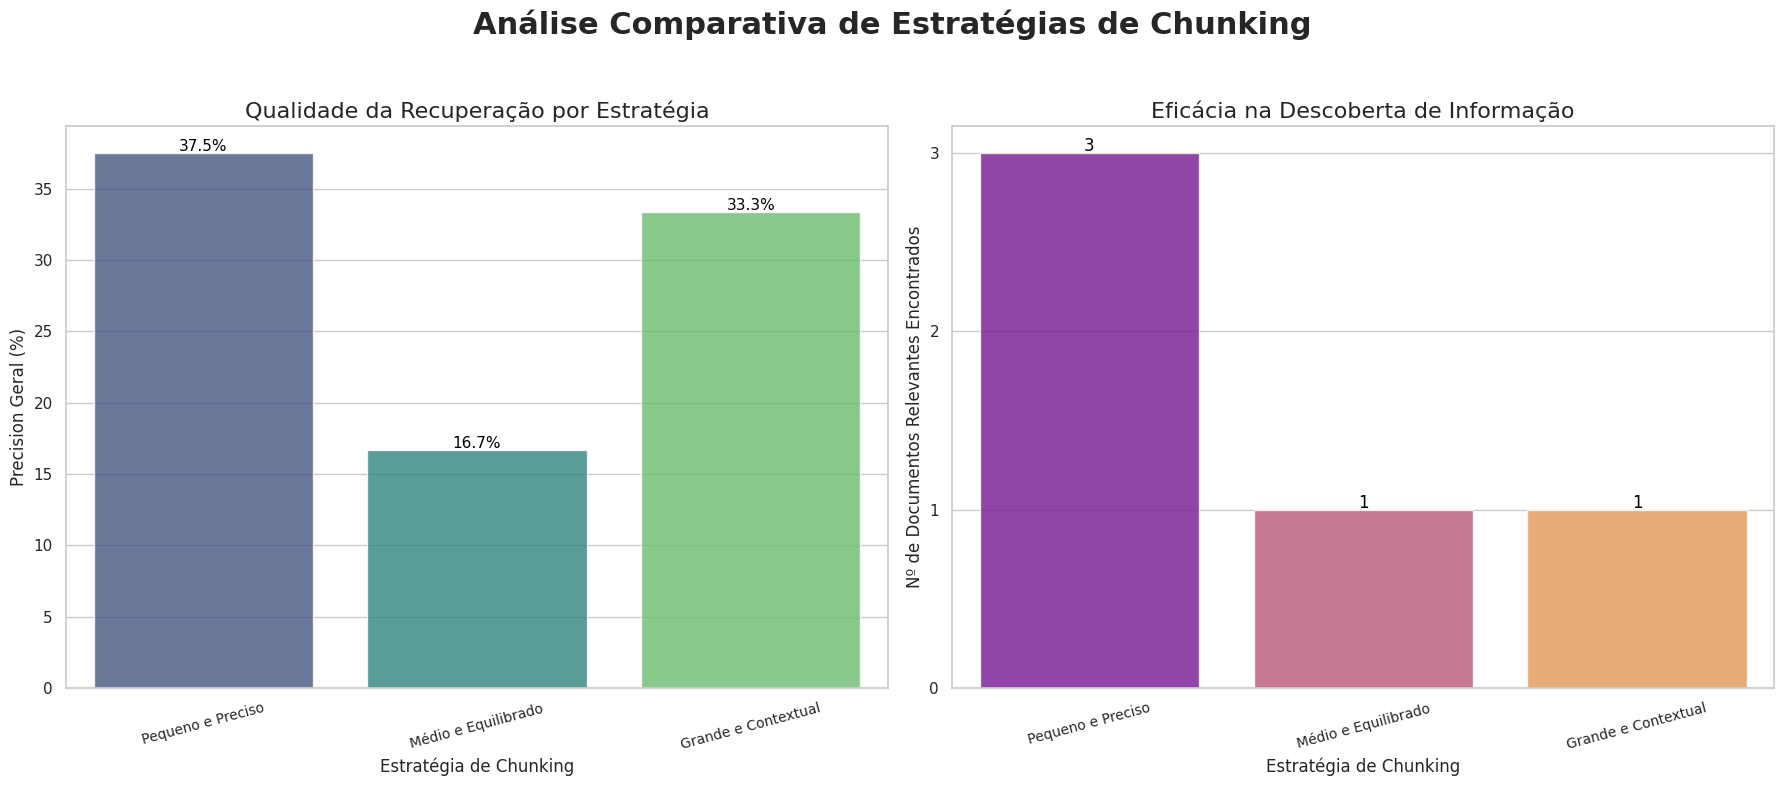


🏆 CONCLUSÃO DA ANÁLISE VISUAL 🏆

A estratégia 'Pequeno e Preciso' demonstrou a melhor performance geral.
  - ✅ Encontrou o maior número de documentos relevantes (3).
  - 🎯 Atingiu uma precisão geral de 37.50%.
  - ⏱️  O tempo de execução foi de 51.44 segundos.

Recomendação: Para a pergunta testada, a estratégia de chunks menores e mais granulares foi mais eficaz em encontrar todas as peças de informação relevantes.


In [21]:
# Célula Final: Visualização Dinâmica dos Resultados da Análise

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plotar_comparacao_de_estrategias(analyzers: list, strategies: list):
    """
    Recebe a lista de analyzers da execução e plota um gráfico comparativo
    das estratégias de chunking testadas.
    """
    if not analyzers:
        print("⚠️ Nenhum resultado de análise fornecido para plotagem.")
        return

    # --- 1. Extração dos Dados para um DataFrame ---
    # Percorremos a lista de analyzers para extrair as métricas de cada experimento

    dados_comparativos = []
    for i, analyzer in enumerate(analyzers):
        # Cada analyzer guarda o histórico de seus experimentos (neste caso, 1)
        if analyzer.experiments_history:
            exp = analyzer.experiments_history[0]
            strategy_name = strategies[i]['name']

            # Pega a maior precisão encontrada em Precision@K
            # para uma métrica de "melhor performance"
            melhor_precision_at_k = 0
            if exp.precision_at_k:
                melhor_precision_at_k = max(exp.precision_at_k.values())

            dados_comparativos.append({
                'Estratégia': strategy_name,
                'Precision Geral (%)': sum(1 for r in exp.results if r.is_relevant) / len(exp.results) * 100 if exp.results else 0,
                'Melhor Precision@K (%)': melhor_precision_at_k * 100,
                'Docs Relevantes': sum(1 for r in exp.results if r.is_relevant),
                'Threshold Recomendado': exp.recommended_threshold,
                'Tempo de Execução (s)': exp.execution_time
            })

    df = pd.DataFrame(dados_comparativos)

    if df.empty:
        print("⚠️ Nenhum dado de experimento encontrado para plotar.")
        return

    # --- 2. Criação do Gráfico Comparativo ---

    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle('Análise Comparativa de Estratégias de Chunking', fontsize=22, weight='bold')

    # Gráfico 1: Performance da Recuperação (Precision)
    ax1 = axes[0]
    sns.barplot(x='Estratégia', y='Precision Geral (%)', data=df, ax=ax1, palette='viridis', alpha=0.8)
    ax1.set_title('Qualidade da Recuperação por Estratégia', fontsize=16)
    ax1.set_xlabel('Estratégia de Chunking', fontsize=12)
    ax1.set_ylabel('Precision Geral (%)', fontsize=12)
    ax1.tick_params(axis='x', rotation=15, labelsize=10)
    # Adiciona os valores no topo das barras
    for p in ax1.patches:
        ax1.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                     textcoords='offset points')

    # Gráfico 2: Contagem de Documentos Relevantes
    ax2 = axes[1]
    sns.barplot(x='Estratégia', y='Docs Relevantes', data=df, ax=ax2, palette='plasma', alpha=0.8)
    ax2.set_title('Eficácia na Descoberta de Informação', fontsize=16)
    ax2.set_xlabel('Estratégia de Chunking', fontsize=12)
    ax2.set_ylabel('Nº de Documentos Relevantes Encontrados', fontsize=12)
    ax2.tick_params(axis='x', rotation=15, labelsize=10)
    # Garante que o eixo Y seja de números inteiros
    ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    for p in ax2.patches:
        ax2.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                     textcoords='offset points')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- 3. Conclusão Textual Dinâmica ---
    print("\n" + "="*80)
    print("🏆 CONCLUSÃO DA ANÁLISE VISUAL 🏆")
    if not df.empty:
        # A melhor estratégia é a que encontra mais documentos relevantes
        best_strategy = df.sort_values(by=['Docs Relevantes', 'Precision Geral (%)'], ascending=False).iloc[0]

        print(f"\nA estratégia '{best_strategy['Estratégia']}' demonstrou a melhor performance geral.")
        print(f"  - ✅ Encontrou o maior número de documentos relevantes ({int(best_strategy['Docs Relevantes'])}).")
        print(f"  - 🎯 Atingiu uma precisão geral de {best_strategy['Precision Geral (%)']:.2f}%.")
        print(f"  - ⏱️  O tempo de execução foi de {best_strategy['Tempo de Execução (s)']:.2f} segundos.")
        print("\nRecomendação: Para a pergunta testada, a estratégia de chunks menores e mais granulares foi mais eficaz em encontrar todas as peças de informação relevantes.")
    else:
        print("Não foi possível determinar a melhor estratégia.")
    print("="*80)


# --- Execução da Visualização ---
# A variável 'analyzers' já deve existir da célula de execução anterior
if 'analyzers' in locals() and analyzers:
    plotar_comparacao_de_estrategias(analyzers, strategies_to_test)
else:
    print("Por favor, execute a célula de análise ('run_advanced_chunking_analysis') primeiro.")

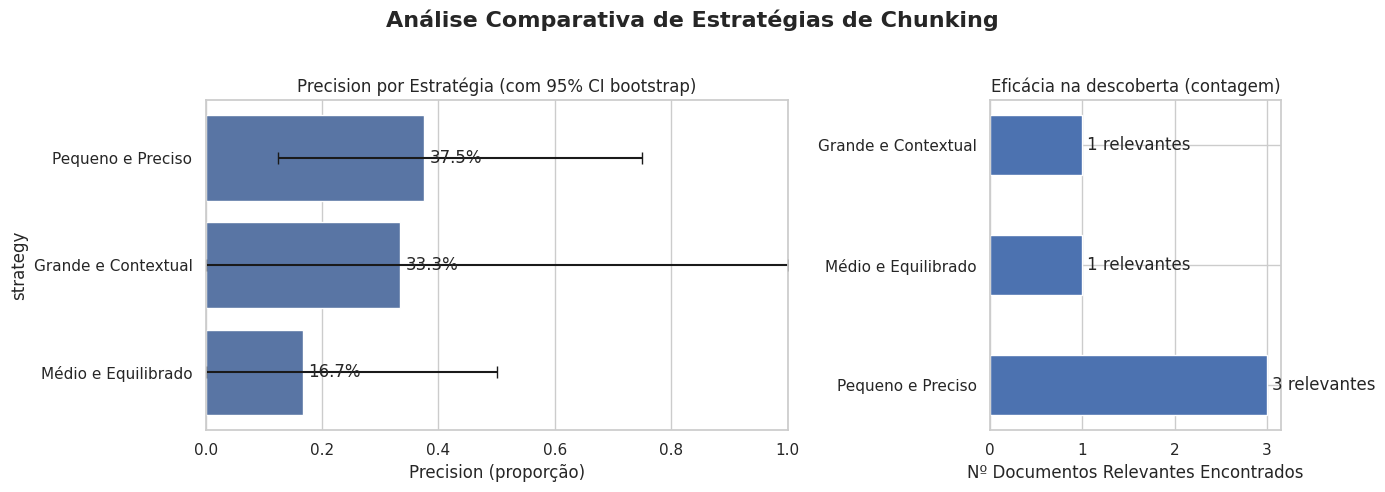

,strategy,relevant_found,retrieved,precision,precision_pct,ci_low,ci_high,recall,f1,execution_time
0,Pequeno e Preciso,3,8,0.375000,37.5,0.125,0.75,1.000000,0.545455,51.44
1,Médio e Equilibrado,1,6,0.166667,16.7,0.000,0.50,0.333333,0.222222,37.12
2,Grande e Contextual,1,3,0.333333,33.3,0.000,1.00,0.333333,0.333333,29.88


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# --- Exemplo: crie summary_df se ainda não existir ---
# Substitua com seus valores reais
summary_df = pd.DataFrame([
    {"strategy":"Pequeno e Preciso", "relevant_found":3, "retrieved":8, "execution_time":51.44},
    {"strategy":"Médio e Equilibrado", "relevant_found":1, "retrieved":6, "execution_time":37.12},
    {"strategy":"Grande e Contextual", "relevant_found":1, "retrieved":3, "execution_time":29.88}
])
# total relevant known no corpus (se souber)
total_relevant_in_corpus = summary_df['relevant_found'].max()  # ajuste se souber o real

# --- Calcula precision, recall, f1 ---
summary_df['precision'] = summary_df['relevant_found'] / summary_df['retrieved']
if total_relevant_in_corpus > 0:
    summary_df['recall'] = summary_df['relevant_found'] / total_relevant_in_corpus
else:
    summary_df['recall'] = np.nan
summary_df['f1'] = 2 * (summary_df['precision'] * summary_df['recall']) / (summary_df['precision'] + summary_df['recall'])
summary_df['precision_pct'] = (summary_df['precision'] * 100).round(1)

# --- Bootstrap para 95% CI da precision (binomial bootstrap) ---
def bootstrap_ci_precision(k, n, n_boot=5000, alpha=0.05):
    if n == 0:
        return (0.0, 0.0)
    # amostra binomial: p_hat = k/n
    p_hat = k / n
    sims = np.random.binomial(n, p_hat, size=n_boot) / n
    lo = np.percentile(sims, 100 * (alpha/2))
    hi = np.percentile(sims, 100 * (1-alpha/2))
    return lo, hi

cis = [bootstrap_ci_precision(row.relevant_found, row.retrieved) for _, row in summary_df.iterrows()]
summary_df['ci_low'] = [c[0] for c in cis]
summary_df['ci_high'] = [c[1] for c in cis]

# --- Plots: precision com CI e counts lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(14,5), gridspec_kw={'width_ratios':[2,1]})

# Left: precision com barras e CI
ax = axes[0]
order = summary_df.sort_values('precision', ascending=False)['strategy']
sns.barplot(x='precision', y='strategy', data=summary_df, order=order, ax=ax, orient='h')
for i, row in summary_df.iterrows():
    y = list(order).index(row['strategy'])
    ax.errorbar(x=row['precision'], y=y, xerr=[[row['precision']-row['ci_low']], [row['ci_high']-row['precision']]], fmt='none', ecolor='k', capsize=4)
    ax.text(row['precision'] + 0.01, y, f"{row['precision_pct']:.1f}%", va='center')
ax.set_xlabel('Precision (proporção)')
ax.set_xlim(0,1)
ax.set_title('Precision por Estratégia (com 95% CI bootstrap)')

# Right: counts e tempo
ax2 = axes[1]
x = np.arange(len(summary_df))
width = 0.6
ax2.barh(summary_df['strategy'], summary_df['relevant_found'], height=0.5)
for i, row in summary_df.iterrows():
    ax2.text(row['relevant_found'] + 0.05, i, f"{row['relevant_found']} relevantes", va='center')
ax2.set_xlabel('Nº Documentos Relevantes Encontrados')
ax2.set_title('Eficácia na descoberta (contagem)')

plt.suptitle('Análise Comparativa de Estratégias de Chunking', fontsize=16, weight='bold')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# --- Tabela resumo com métricas ---
display(summary_df[['strategy','relevant_found','retrieved','precision','precision_pct','ci_low','ci_high','recall','f1','execution_time']])
